In [1]:
# This file plays the mpc motion only in viz

import time
import numpy as np
import pinocchio as pin
import crocoddyl
from matplotlib import pyplot as plt
%matplotlib notebook 

from py_biconvex_mpc.motion_planner.cpp_biconvex import BiConvexMP
from py_biconvex_mpc.ik_utils.gait_generator import GaitGenerator
from robot_properties_solo.config import Solo12Config
from abstract_mpc_gait_gen import SoloMpcGaitGen
from weight_abstract import BiconvexMotionParams
# from solo12_gait_params import trot, walk


solo import 


In [2]:
robot = Solo12Config.buildRobotWrapper()
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()
pin_robot = Solo12Config.buildRobotWrapper()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [15]:

bound = BiconvexMotionParams("solo12", "bound")

# Cnt
bound.gait_period = 0.4
bound.stance_percent = [0.5, 0.5, 0.5, 0.5]
bound.gait_dt = 0.05
bound.phase_offset = [0.0, 0.0, 0.5, 0.5]

# IK
bound.state_wt = np.array([0., 0, 1e3] + [10, 10, 10] + [100.0] * (pin_robot.model.nv - 6) \
                        + [0.00] * 3 + [100, 10, 100] + [0.5] *(pin_robot.model.nv - 6))

bound.ctrl_wt = [0.5, 0.5, 0.5] + [2, 2, 2] + [0.5] *(pin_robot.model.nv - 6)

bound.swing_wt = [1e4, 1e4]
bound.cent_wt = [0*5e+1, 0*1e+2]
bound.step_ht = 0.07
bound.reg_wt = [7e-3, 7e-5]

# Dyn 
bound.W_X =        np.array([1e-5, 1e-5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+4, 1e+3, 1e+3])
bound.W_X_ter = 10*np.array([1e+5, 1e-5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+4, 1e+3, 1e+3])
bound.W_F = np.array(4*[1e+1, 1e+1, 1e+1])
bound.nom_ht = 0.2
bound.rho = 5e+4
bound.ori_correction = [0.3, 0.3, 0.7]
bound.gait_horizon = 1.0

# Gains
bound.kp = 3.0
bound.kd = 0.05

In [18]:
## Motion
gait_params = bound

## robot config and init
urdf_path = Solo12Config.urdf_path
gait_time = gait_params.gait_period
dt = 5e-2

n_eff = 4
q0 = np.array(Solo12Config.initial_configuration)
# q0[7:13] = 2 * [0.0, -0.8, 1.6]

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.0,0.0, 0])
step_height = gait_params.step_ht

plan_freq = 0.05 # sec
update_time = 0.02 # sec (time of lag)

gg = SoloMpcGaitGen(pin_robot, urdf_path, dt, gait_params, x0, plan_freq, q0)

# gg.update_params(swing_wt = [1e4,1e3], cent_wt= [1e3, 1e1], nom_ht = 0.2)

# while True:
n = 1

sim_t = 0.0
step_t = 0
sim_dt = .001
index = 0

tmp = []
tmp_des = []

# robot.robot_tsid_ctrl.set_gains(0.0, 0, 40.0, 0)

In [5]:
viz.viewer.jupyter_cell()

In [20]:
q = q0
v = v0
step_t = 0
n = 0
for o in range(60):
    contact_configuration = np.array([1,1,1,1])
        
    xs, us, f = gg.optimize(q, v, np.round(step_t,3), v_des, gait_params.step_ht, contact_configuration)
#     print(gg.cnt_plan[0:2])
#     print(gg.cnt_plan)  
#     print("------------------------------------------")
    
    if o == 0:
        plt_f = f[:int(plan_freq/sim_dt)]
        plt_xs = xs[:int(plan_freq/sim_dt)]
        plt_com = gg.com_int[:int(plan_freq/sim_dt)]
        plt_mom = gg.mom_int[:int(plan_freq/sim_dt)]
        
    else:
        plt_f = np.vstack((plt_f, f[:int(plan_freq/sim_dt)]))
        plt_xs = np.vstack((plt_xs, xs[:int(plan_freq/sim_dt)]))
        plt_com = np.vstack((plt_com, gg.com_int[:int(plan_freq/sim_dt)]))
        plt_mom = np.vstack((plt_mom, gg.mom_int[:int(plan_freq/sim_dt)]))
        
        
    gg.reset()
    for ind in range(int(plan_freq/sim_dt)):
        viz.display(xs[ind][:robot.model.nq])
    
    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq]
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:]
    step_t = (step_t + plan_freq)%gait_params.gait_period


breaking outer loop due to norm ...
Maximum iterations reached 
Final norm: 0.000952038


ZMQError: Operation cannot be accomplished in current state

<IPython.core.display.Javascript object>


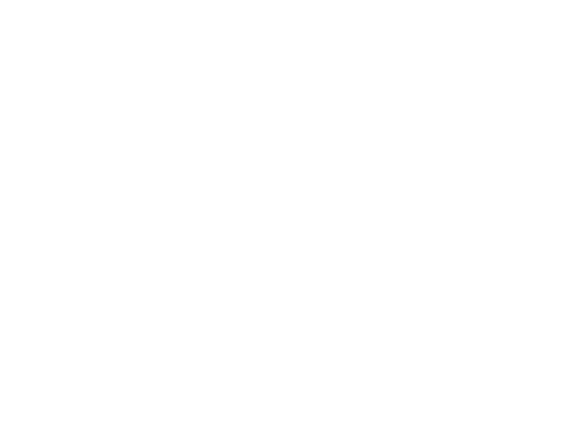

In [7]:
%matplotlib notebook 

t = 0.001*np.arange(0, len(plt_f))

fig  = plt.figure(1)
plt.plot(t, plt_f[:,2], label = "FL_Z")
plt.plot(t, plt_f[:,5], label = "FR_Z")
# ax.plot(t, plt_f[:,8], label = "HL_Z")
# ax.plot(t, plt_f[:,11], label = "HR_Z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


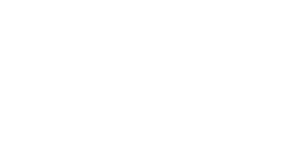

In [8]:
%matplotlib notebook 

plt.plot(t, plt_com[:,0], label = "com_x")
plt.plot(t, plt_com[:,1], label = "com_y")
plt.plot(t, plt_com[:,2], label = "com_z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


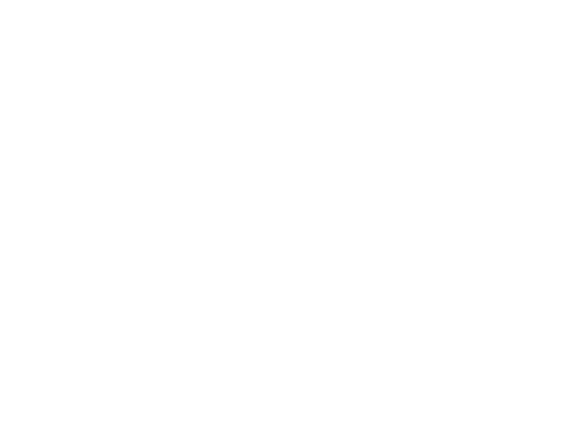

In [9]:
%matplotlib notebook 

plt.plot(t, plt_mom[:,0], label = "mom_x")
plt.plot(t, plt_mom[:,1], label = "mom_y")
plt.plot(t, plt_mom[:,2], label = "mom_z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


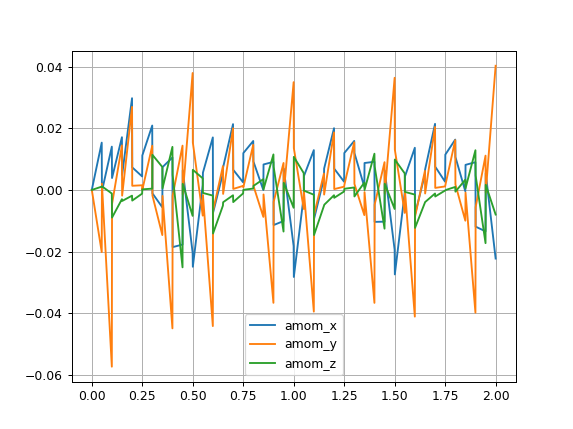

In [10]:
%matplotlib notebook 

plt.plot(t, plt_mom[:,3], label = "amom_x")
plt.plot(t, plt_mom[:,4], label = "amom_y")
plt.plot(t, plt_mom[:,5], label = "amom_z")
plt.grid()
plt.legend()
plt.show()